In [5]:
import os
import sys
import cv2
import math
import json
import imageio
import numpy as np
import gymnasium as gym
from datetime import datetime
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import (DummyVecEnv, 
                                              VecFrameStack, 
                                              SubprocVecEnv, 
                                              VecTransposeImage
)

# Best agent video
---

In [3]:
def make_video(experiment_start, target_frames=3000):
    video_path = f"results/run_{experiment_start}/dqn_carracing.mp4"
    best_model_path = f"./results/run_{experiment_start}/best_model/best_model.zip"

    print("Loading best model for video generation...")
    model = DQN.load(best_model_path)
    print("Model loaded successfully.")

    eval_env = DummyVecEnv([lambda: gym.make(
        "CarRacing-v3",
        render_mode="rgb_array",
        continuous=False
    )])
    eval_env = VecFrameStack(eval_env, n_stack=4)

    obs = eval_env.reset()
    frames = []

    print(f"Collecting {target_frames} frames for the video...")

    while len(frames) < target_frames:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = eval_env.step(action)
        frame = eval_env.render()
        frames.append(frame)

        if done:
            obs = eval_env.reset()

    eval_env.close()
    print(f"Saving video to {video_path}...")
    imageio.mimsave(video_path, [np.array(f) for f in frames], fps=30)
    print("Video saved successfully.")

    return

In [4]:
make_video("2025-06-29_18-35", target_frames=3000)

Loading best model for video generation...
Model loaded successfully.
Saving video to results/run_2025-06-29_18-35/dqn_carracing.mp4...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved successfully.


## Frames of videos


In [24]:
def make_video_frames(video_path, output_folder='results/frames_output', frame_step=30):
    os.makedirs(output_folder, exist_ok=True)

    reader = imageio.get_reader(video_path)
    fps = reader.get_meta_data()['fps']
    total_frames = reader.count_frames()
    duration_sec = int(total_frames / fps)

    saved_count = 0

    for frame_count, frame in enumerate(reader):
        if frame_count % frame_step == 0:
            current_sec = int(frame_count / fps)

            # Convert RGB (imageio) to BGR (OpenCV) for text overlay
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

            timestamp_text = f"{current_sec} of {duration_sec} sec"

            # Text properties
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            font_color = (255, 255, 255)  # White text
            thickness = 2

            # Calculate text size and position
            (text_width, text_height), baseline = cv2.getTextSize(timestamp_text, font, font_scale, thickness)
            position = (10, 20)

            # Black rectangle background for text
            cv2.rectangle(frame_bgr,
                          (position[0] - 2, position[1] - text_height - baseline - 2),
                          (position[0] + text_width + 2, position[1] + 2),
                          (0, 0, 0),
                          cv2.FILLED)

            # Overlay text
            cv2.putText(frame_bgr, timestamp_text, position, font, font_scale, font_color, thickness)

            # Save frame
            frame_filename = os.path.join(output_folder, f'frame_{saved_count:04d}.png')
            cv2.imwrite(frame_filename, frame_bgr)
            saved_count += 1

    reader.close()
    print(f"Saved {saved_count} frames to '{output_folder}'")



def plot_all_frames(frames_folder, output_name, total_frames=30, cols=6, skip_first=3):
    frames_to_plot = total_frames - skip_first
    rows = math.ceil(frames_to_plot / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 1.75))
    axes = axes.flatten()

    for i in range(skip_first, total_frames):
        frame_idx = i - skip_first
        frame_path = os.path.join(frames_folder, f'frame_{i:04d}.png')
        img = cv2.imread(frame_path)
        if img is None:
            print(f"Warning: Could not read {frame_path}")
            continue
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[frame_idx].imshow(img_rgb)
        axes[frame_idx].axis('off')

    # Turn off any unused subplots (if total_frames is not divisible by cols)
    for j in range(frames_to_plot, rows * cols):
        axes[j].axis('off')

    # Adjust layout to reduce white space
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05,
                        wspace=0.05, hspace=0.05)
    #save
    plt.savefig(f'results/{output_name}.png', bbox_inches='tight', dpi=300)
    plt.show()

In [16]:
video_path = "results/run_2025-06-29_18-35/dqn_carracing.mp4"
make_video_frames(video_path, "results/run_2025-06-29_18-35/frames_output")

Saved 100 frames to 'results/run_2025-06-29_18-35/frames_output'


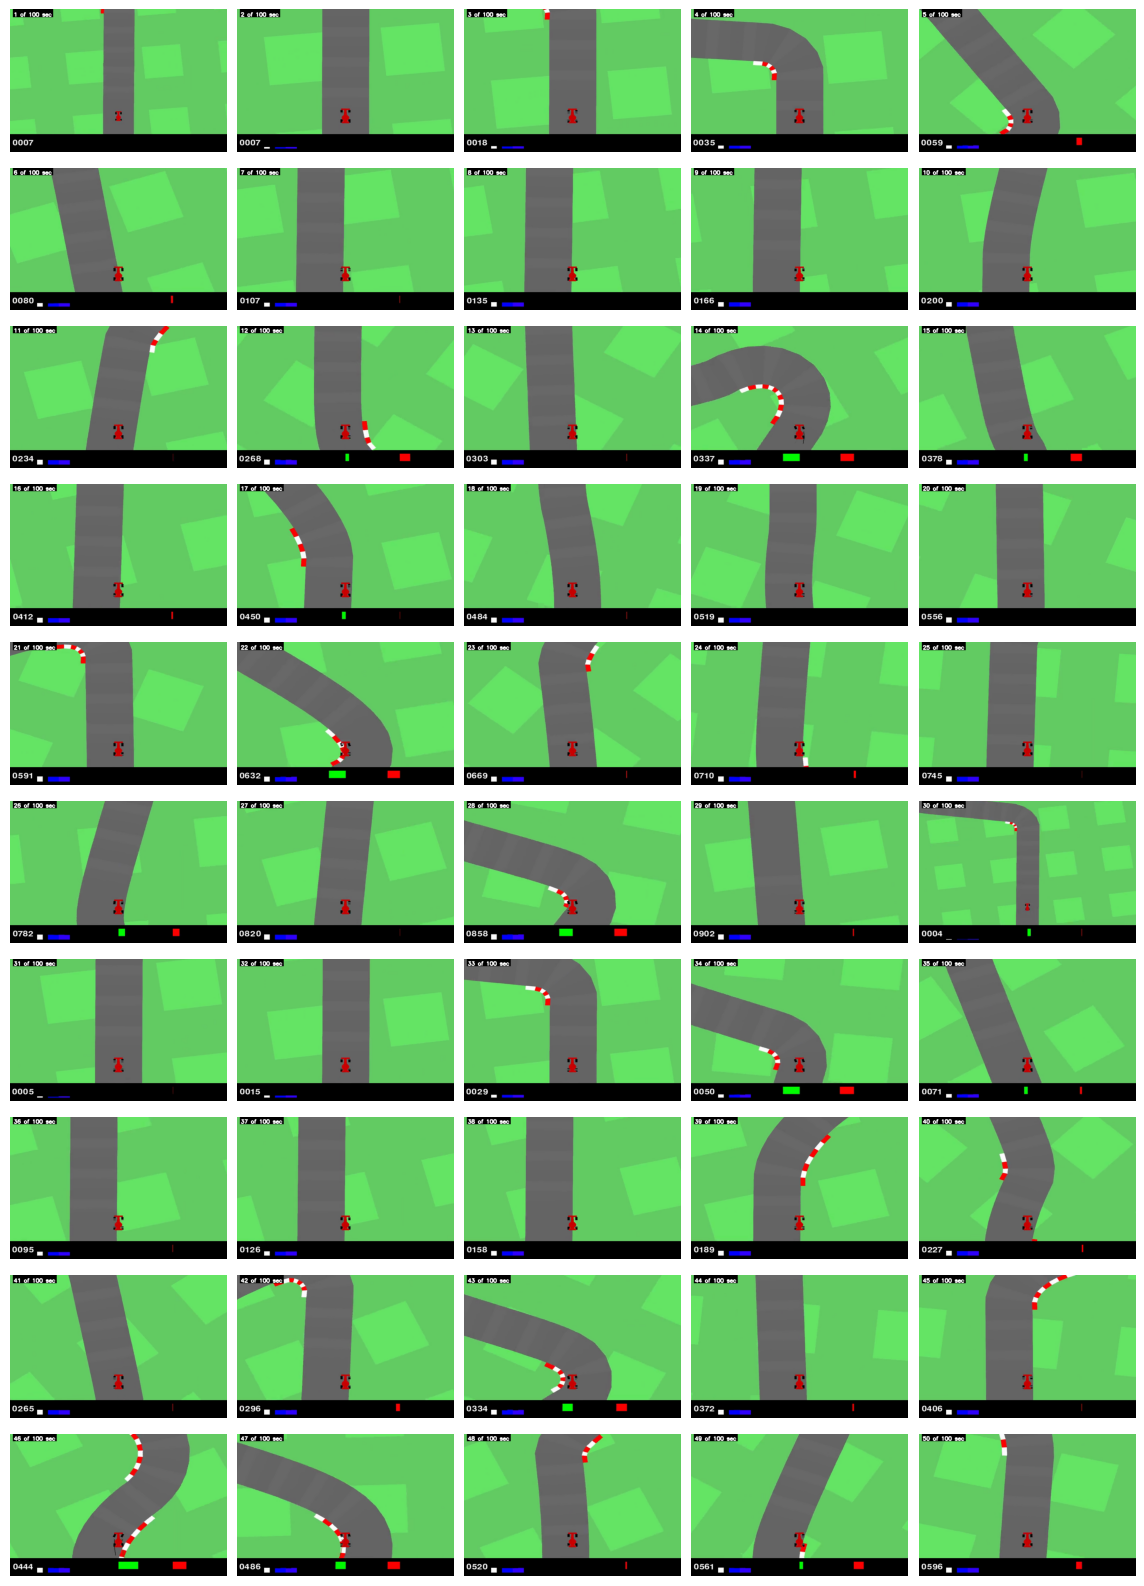

In [29]:
plot_all_frames('results/run_2025-06-29_18-35/frames_output', 'frames_output_1', total_frames=51, cols=5, skip_first=1)

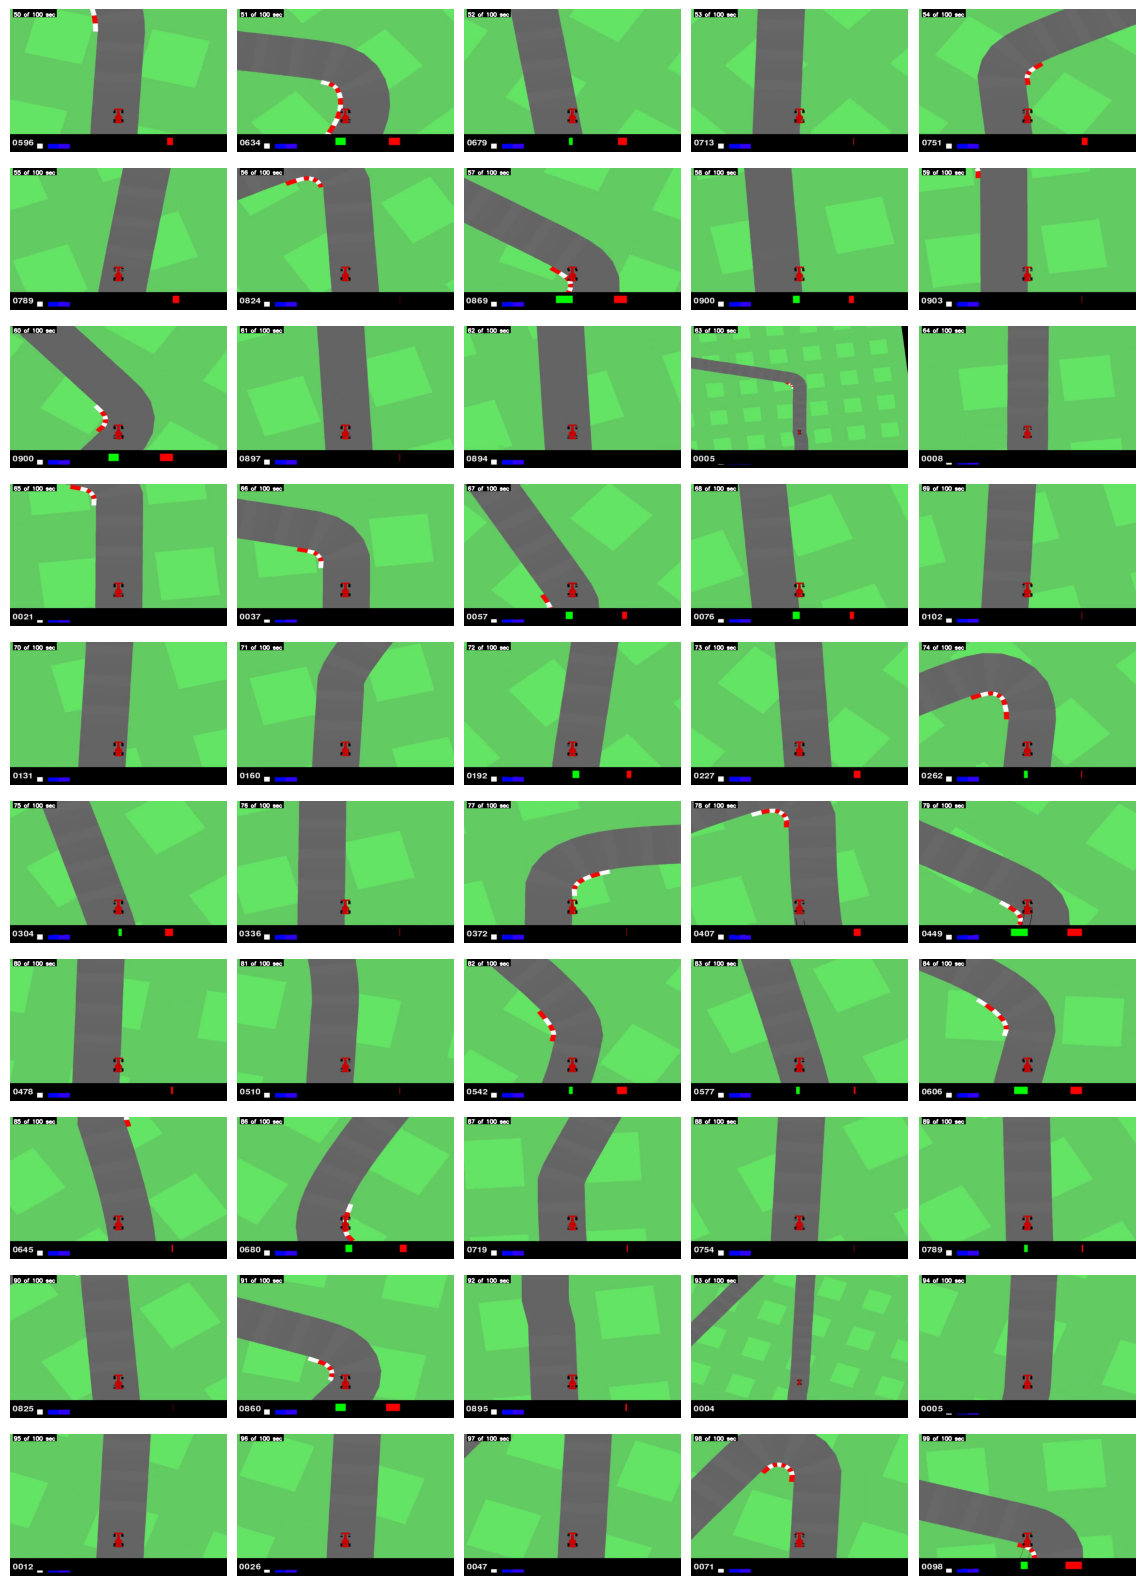

In [ ]:
plot_all_frames('results/run_2025-06-29_18-35/frames_output', 'frames_output_2', total_frames=100, cols=5, skip_first=50)

# MP4 to GIF
---

In [31]:
def mp4_to_gif(video_path, gif_path, fps=30):
    if not os.path.exists(video_path):
        print(f"Error: Video file '{video_path}' does not exist.")
        return

    print(f"Converting '{video_path}' to GIF...")

    reader = imageio.get_reader(video_path)
    frames = [frame for frame in reader]
    reader.close()

    imageio.mimsave(gif_path, frames, fps=fps)
    print(f"GIF saved to '{gif_path}'")

In [32]:
mp4_to_gif("results/run_2025-06-29_18-35/dqn_carracing.mp4", "results/run_2025-06-29_18-35/dqn_carracing.gif", fps=30)

Converting 'results/run_2025-06-29_18-35/dqn_carracing.mp4' to GIF...
GIF saved to 'results/run_2025-06-29_18-35/dqn_carracing.gif'


# CNN Environment Processing
---

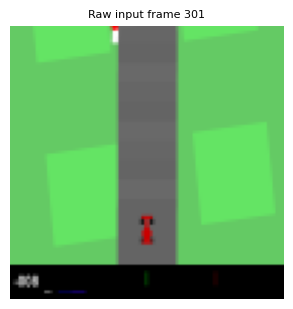

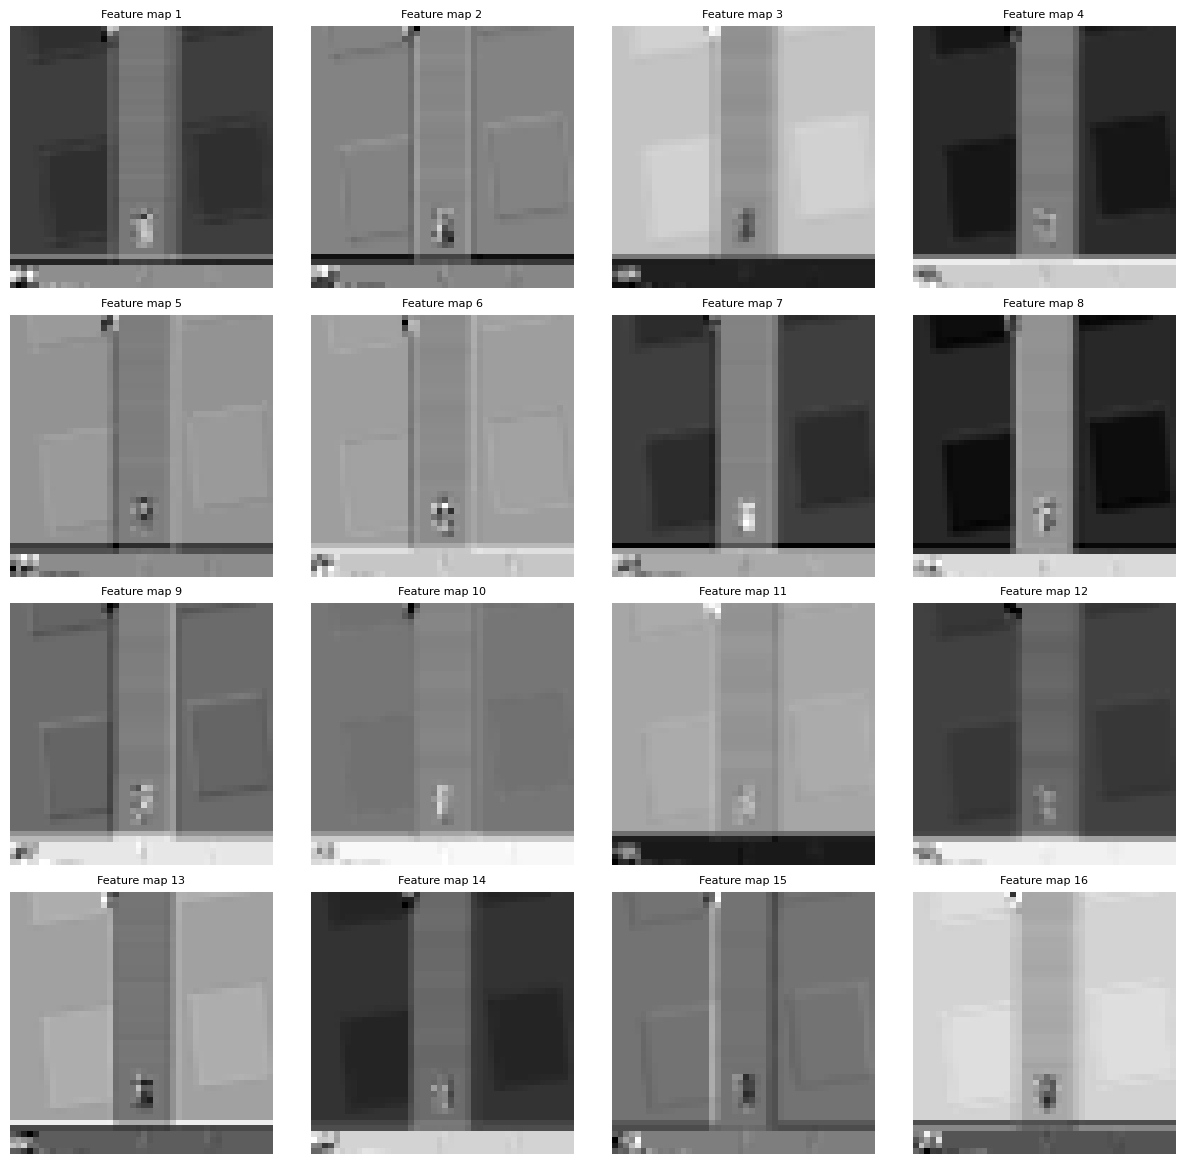

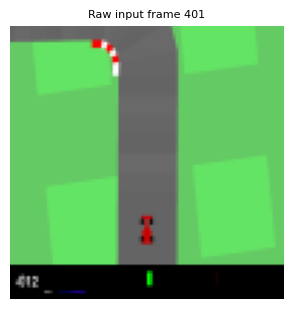

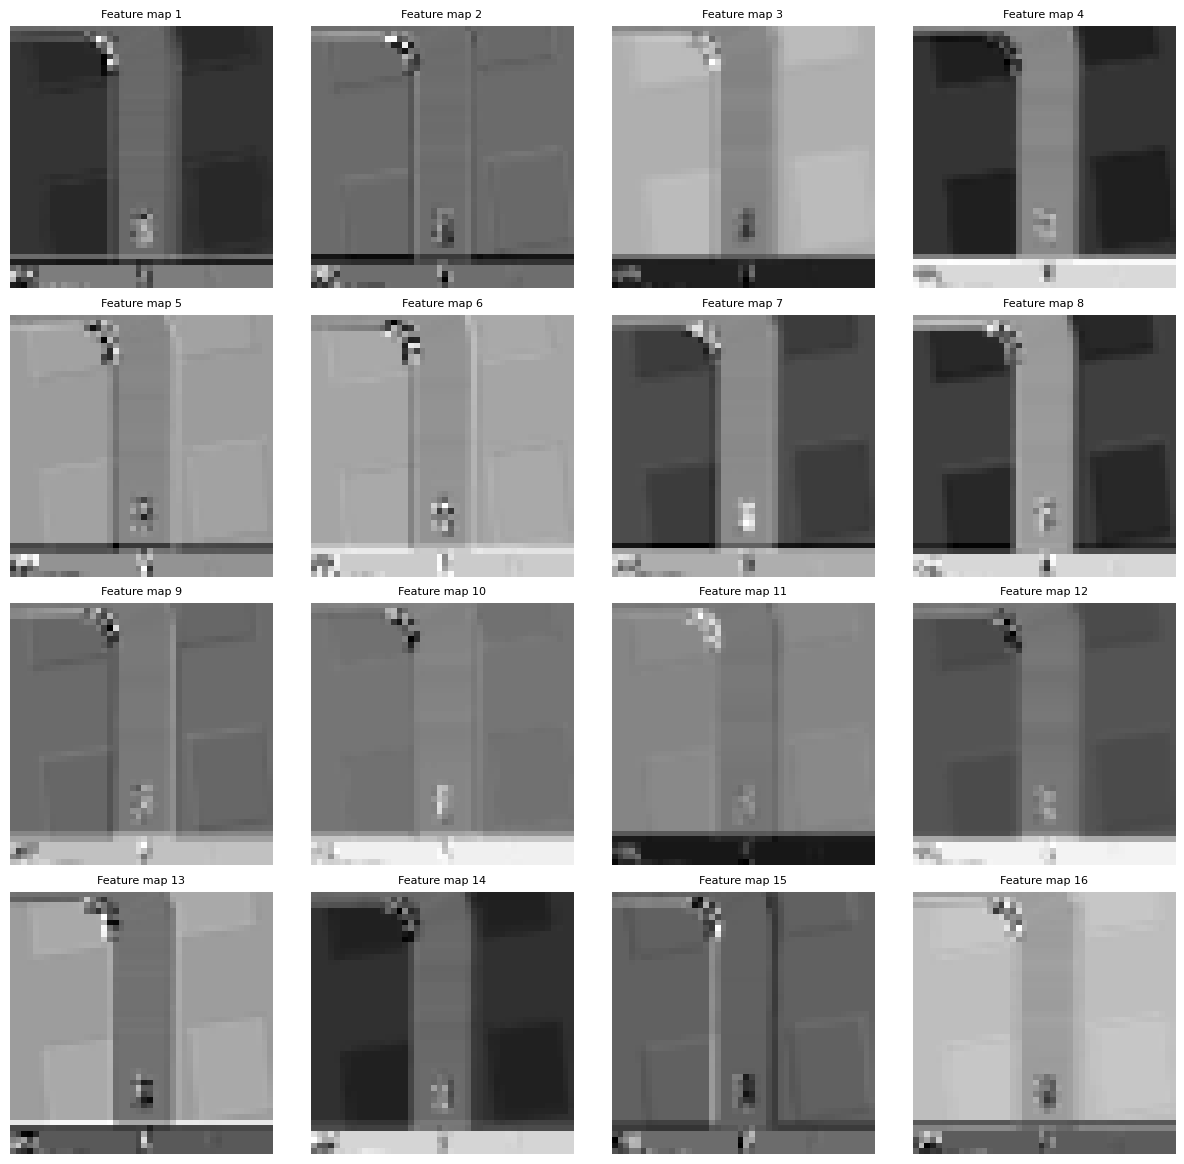

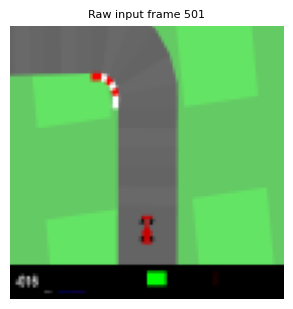

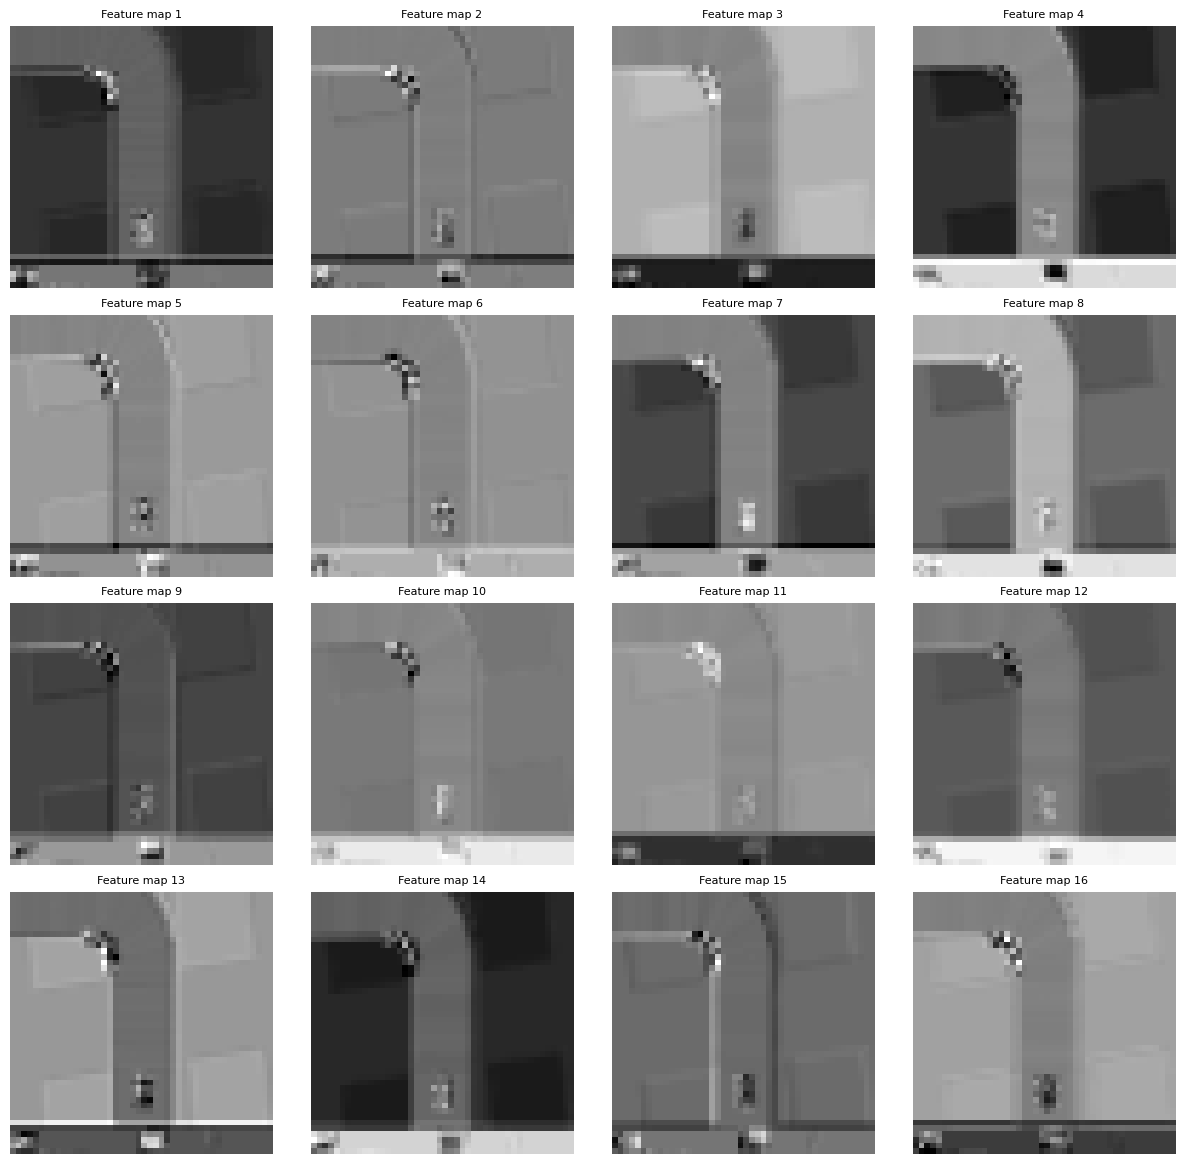

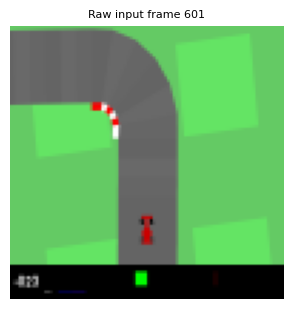

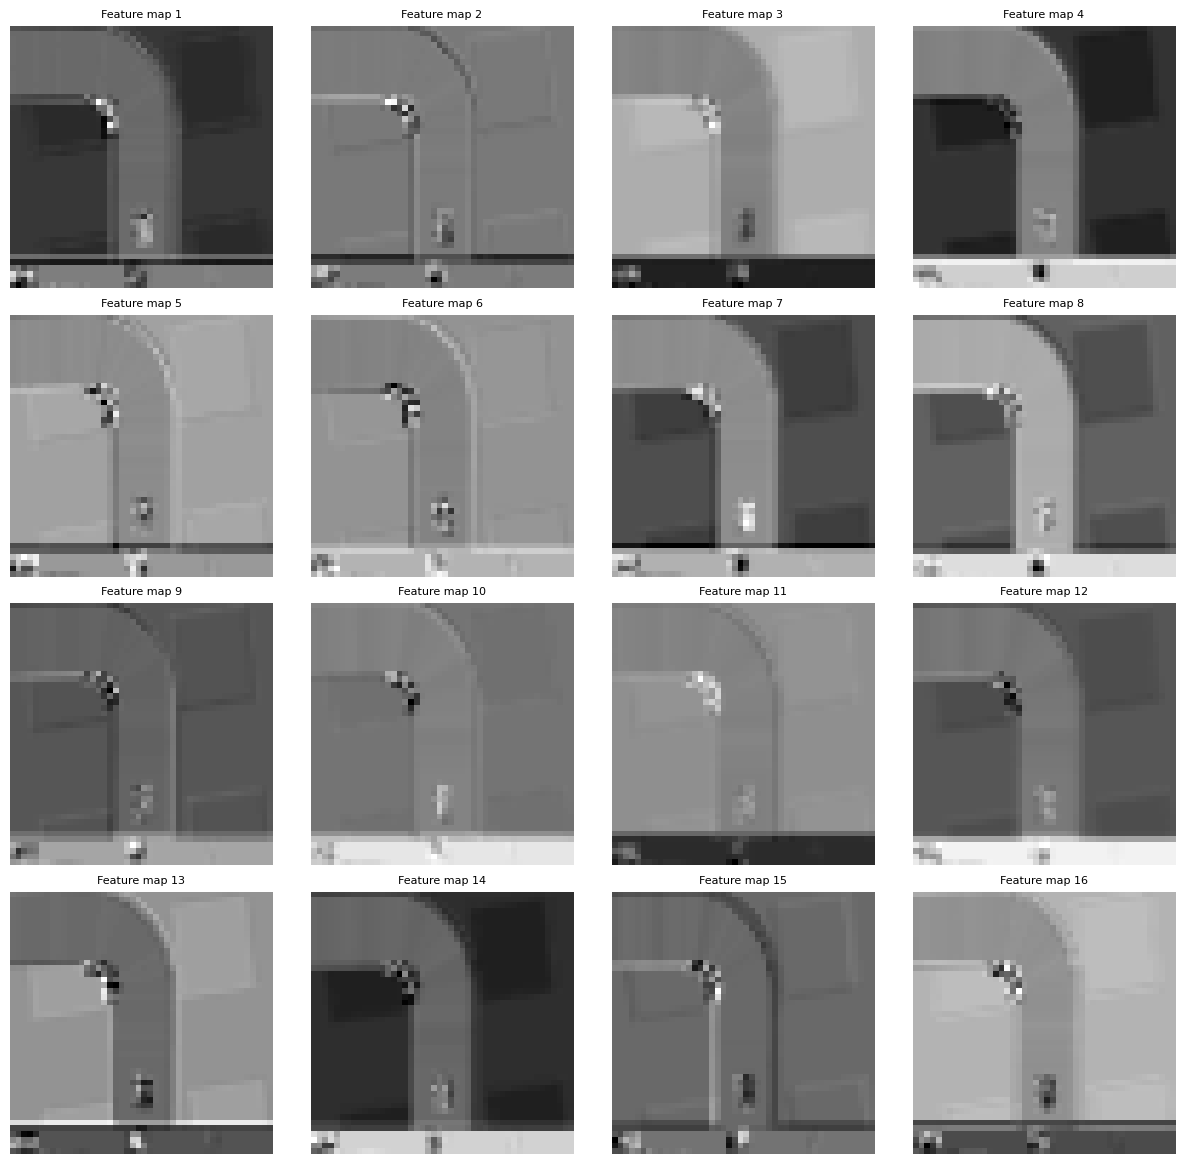

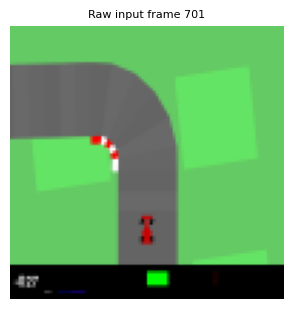

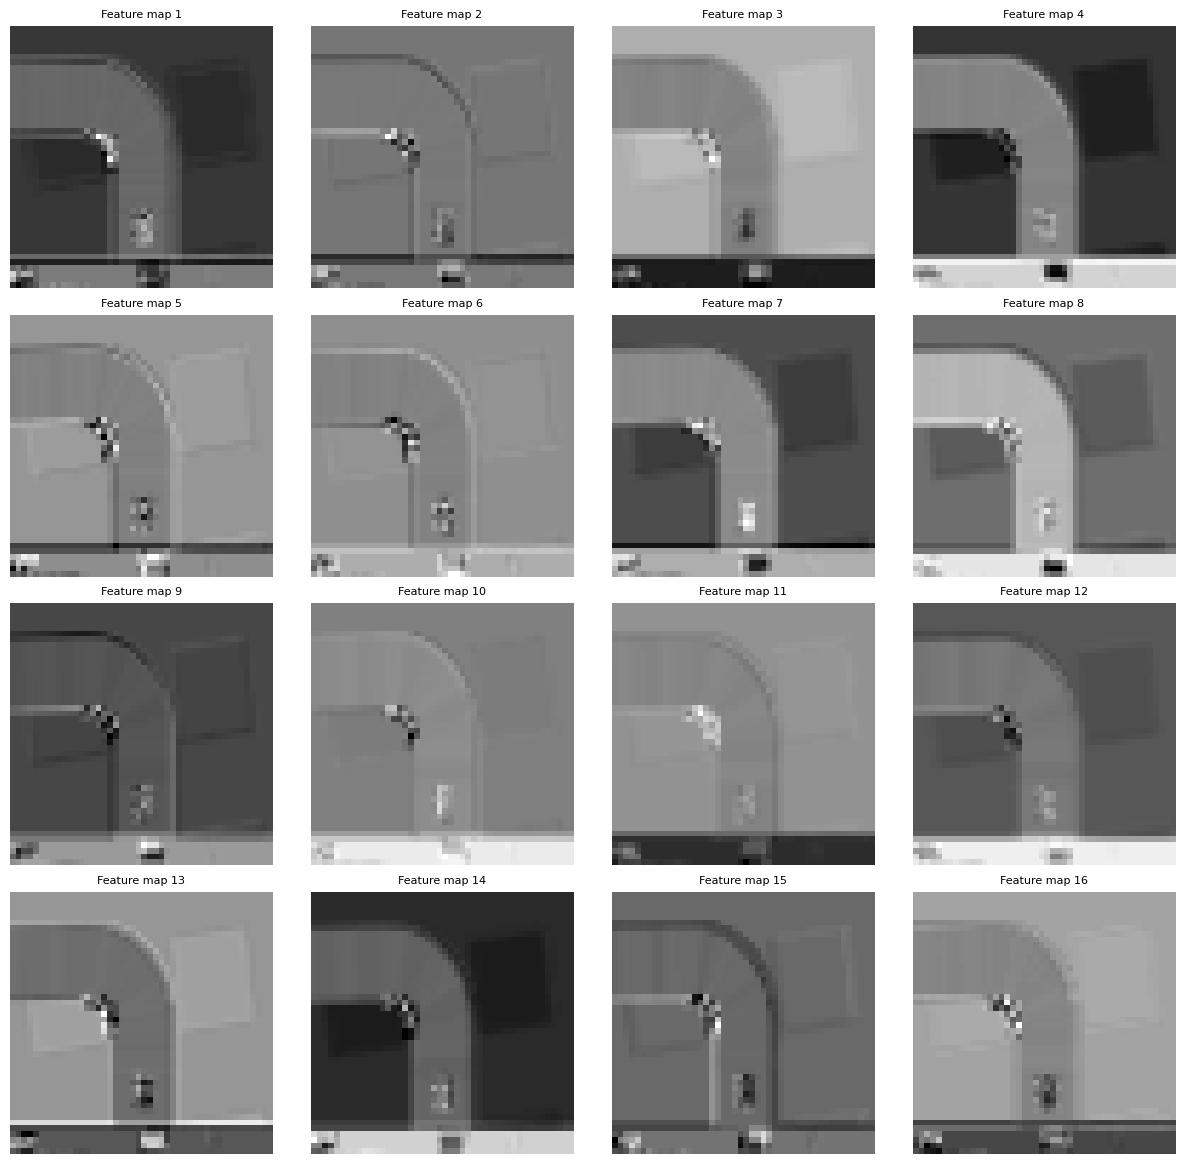

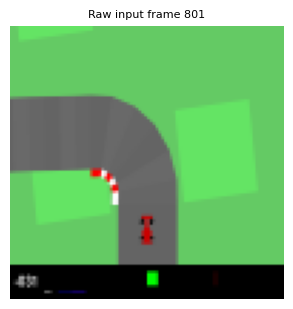

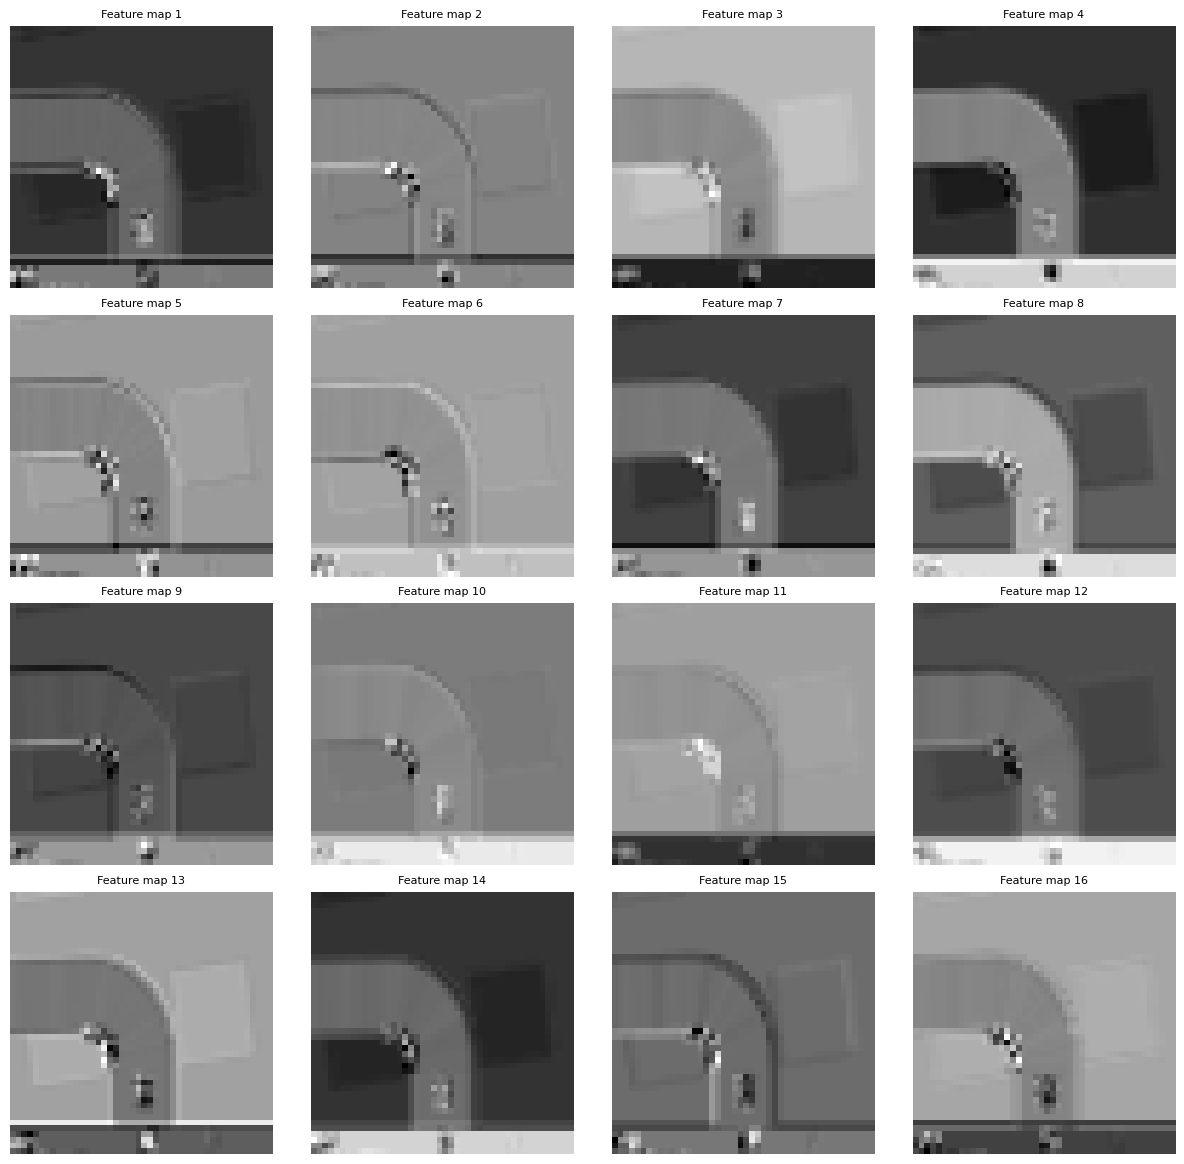

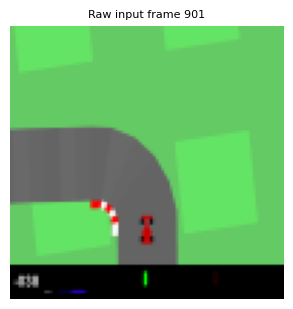

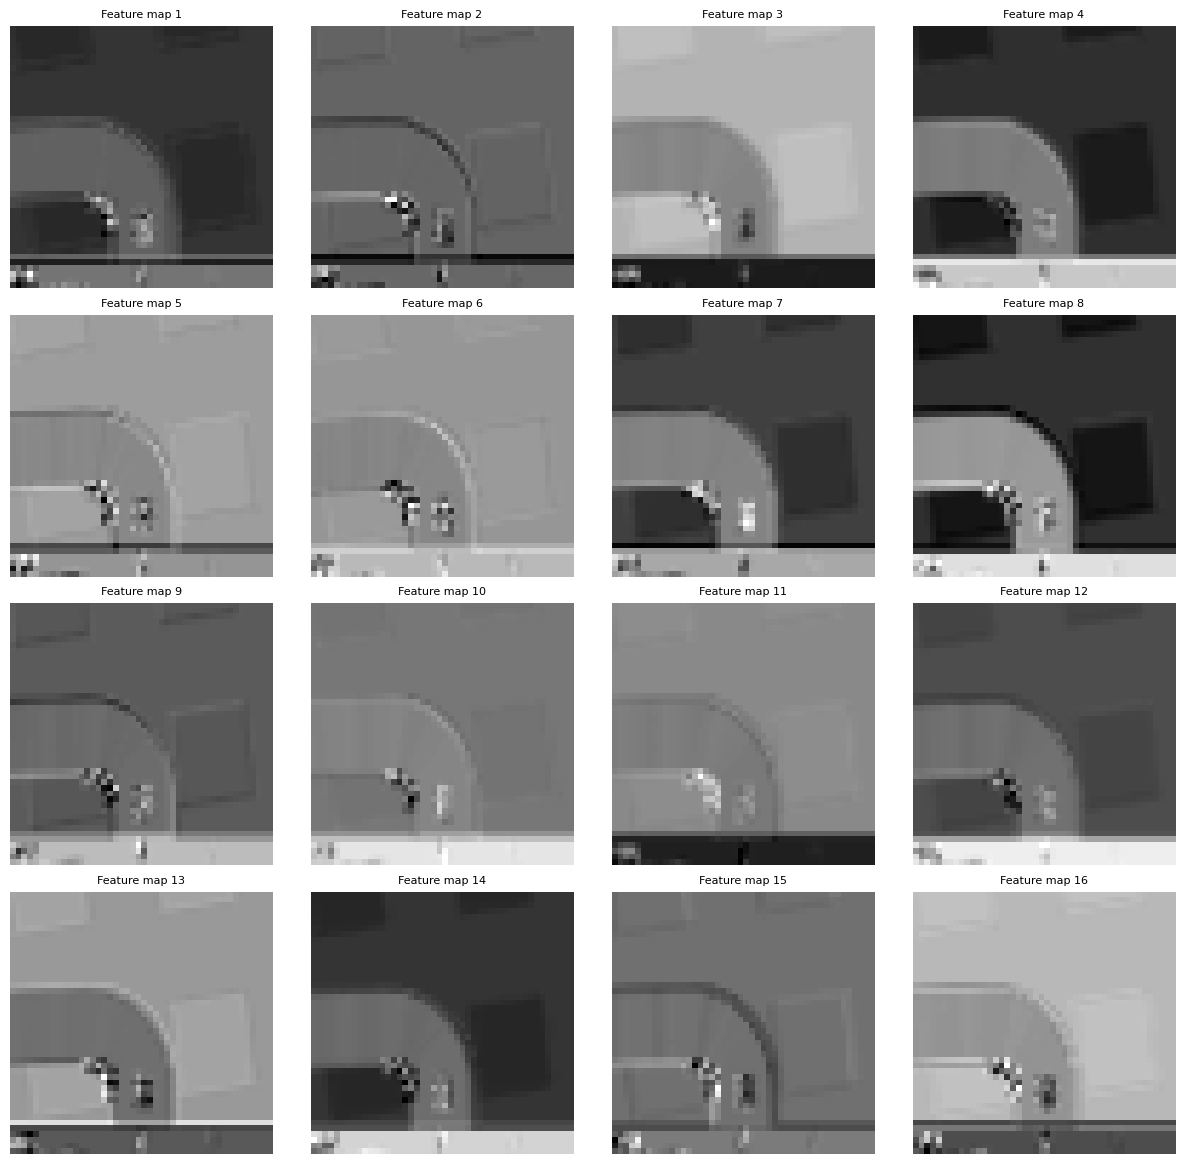

In [72]:
import gymnasium as gym
import torch
import torch.nn as nn
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

# Simple CNN with 2 conv layers
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        return x

# Helper to show images (single or multiple feature maps)
def show_images(images, titles=None, cols=4, base_size=3):
    import matplotlib.pyplot as plt
    
    n = len(images)
    rows = (n + cols - 1) // cols
    figsize = (cols * base_size, rows * base_size)  # dynamic figure size for squares
    
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        if img.ndim == 2:  # single channel
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.axis('off')
        if titles:
            plt.title(titles[i], fontsize=8)
    
    plt.subplots_adjust(left=0.01, right=0.99, top=0.95, bottom=0.01,
                        wspace=0.1, hspace=0.1)  # smaller gaps
    plt.show()

# Initialize environment and CNN
env = gym.make("CarRacing-v3", render_mode="rgb_array")
cnn = SimpleCNN()

# Preprocessing transform: resize, to tensor, normalize
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((96, 96)),  # smaller for CNN input
    T.ToTensor(),        # convert HWC uint8 [0,255] to CHW float [0,1]
])

# To store activations
activations = {}

# Hook to capture conv1 output
def hook_fn(module, input, output):
    activations['conv1'] = output.detach().cpu()

cnn.conv1.register_forward_hook(hook_fn)

obs, _ = env.reset()

for frame_idx in range(1000):
    frame = obs  # RGB array HWC uint8

    # Preprocess and add batch dimension
    input_tensor = transform(frame).unsqueeze(0)  # shape: (1,3,96,96)

    # Forward pass
    _ = cnn(input_tensor)

    # Visualize input frame
    if frame_idx >200 and frame_idx%100 == 0:
        show_images([frame], titles=[f"Raw input frame {frame_idx+1}"])

    # Get conv1 feature maps
    feature_maps = activations['conv1'][0]  # (16, H, W)

    # Normalize each feature map for better visualization
    feature_maps_np = feature_maps.numpy()
    feature_maps_norm = []
    for fmap in feature_maps_np:
        fmap_min, fmap_max = fmap.min(), fmap.max()
        fmap_norm = (fmap - fmap_min) / (fmap_max - fmap_min + 1e-5)
        feature_maps_norm.append(fmap_norm)

    # Show first 8 feature maps
    if frame_idx >200 and frame_idx%100 == 0:
        show_images(feature_maps_norm, titles=[f"Feature map {i+1}" for i in range(16)], cols=4)

    # Step environment with random action
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        obs, _ = env.reset()
